<a href="https://colab.research.google.com/github/AI-Tiger/ml-project/blob/main/PyTorch_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torch torchvision

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

In [4]:
transform = transforms.Compose( [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [5]:
# 学習データ
train_data_with_teacher_labels = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
train_data_loader = torch.utils.data.DataLoader(train_data_with_teacher_labels, batch_size=4,shuffle=True, num_workers=2)
# 検証データ
test_data_with_teacher_labels = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_data_loader = torch.utils.data.DataLoader(test_data_with_teacher_labels, batch_size=4,shuffle=False, num_workers=2)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
class_names = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [7]:
import matplotlib.pyplot as plt
import numpy as np

In [8]:
def show_image(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

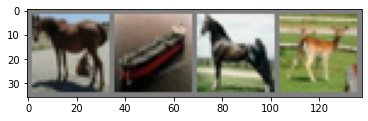

horse  ship horse  deer


In [9]:
# 学習データからちょっとデータを取ってきます
data_iterator = iter(train_data_loader)
images, labels = data_iterator.next()

# 画像を表示します
show_image(torchvision.utils.make_grid(images))
# ラベルを表示します
print(' '.join('%5s' % class_names[labels[j]] for j in range(4)))

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.layer1 = nn.Linear(16 * 5 * 5, 120)
        self.layer2 = nn.Linear(120, 84)
        self.layer3 = nn.Linear(84, 10)

    def forward(self, input_data):
        input_data = self.pool(F.relu(self.conv1(input_data)))
        input_data = self.pool(F.relu(self.conv2(input_data)))
        input_data = input_data.view(-1, 16 * 5 * 5)
        input_data = F.relu(self.layer1(input_data))
        input_data = F.relu(self.layer2(input_data))
        input_data = self.layer3(input_data)
        return input_data

model = CNN()

In [11]:
import torch.optim as optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optimizer.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [12]:
# 最大学習回数
MAX_EPOCH = 3

#
for epoch in range(MAX_EPOCH):

    total_loss = 0.0
    for i, data in enumerate(train_data_loader, 0):
        # dataから学習対象データと教師ラベルデータを取り出します
        train_data, teacher_labels = data

        # 計算された勾配情報を削除します
        optimizer.zero_grad()

        # モデルでの予測を計算します
        outputs = model(train_data)

        # lossとwによる微分計算します
        loss = criterion(outputs, teacher_labels)
        loss.backward()

        # 勾配を更新します
        optimizer.step()
        
        # 誤差を累計します
        total_loss += loss.item()

        # 2000ミニバッチずつ、進捗を表示します
        if i % 2000 == 1999:
            print('学習進捗: [%d, %5d] loss: %.3f' % (epoch + 1, i + 1, total_loss / 2000))
            total_loss = 0.0

print('学習完了')

学習進捗: [1,  2000] loss: 2.221
学習進捗: [1,  4000] loss: 1.840
学習進捗: [1,  6000] loss: 1.689
学習進捗: [1,  8000] loss: 1.615
学習進捗: [1, 10000] loss: 1.547
学習進捗: [1, 12000] loss: 1.503
学習進捗: [2,  2000] loss: 1.439
学習進捗: [2,  4000] loss: 1.377
学習進捗: [2,  6000] loss: 1.355
学習進捗: [2,  8000] loss: 1.356
学習進捗: [2, 10000] loss: 1.325
学習進捗: [2, 12000] loss: 1.305
学習進捗: [3,  2000] loss: 1.229
学習進捗: [3,  4000] loss: 1.221
学習進捗: [3,  6000] loss: 1.210
学習進捗: [3,  8000] loss: 1.236
学習進捗: [3, 10000] loss: 1.210
学習進捗: [3, 12000] loss: 1.191
学習完了


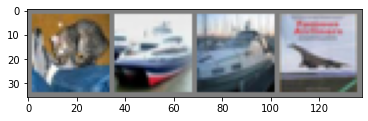

正解教師ラベル:    cat  ship  ship plane


In [13]:
data_iterator = iter(test_data_loader)
images, labels = data_iterator.next()

# 画像を表示します
show_image(torchvision.utils.make_grid(images))
print('正解教師ラベル: ', ' '.join('%5s' % class_names[labels[j]] for j in range(4)))

In [14]:
outputs = model(images)

_, predicted = torch.max(outputs, 1)

print('予測: ', ' '.join('%5s' % class_names[predicted[j]] for j in range(4)))

予測:    dog   car   car  ship


In [15]:
count_when_correct = 0
total = 0
with torch.no_grad():
    for data in test_data_loader:
        test_data, teacher_labels = data
        results = model(test_data)
        _, predicted = torch.max(results.data, 1)
        total += teacher_labels.size(0)
        count_when_correct += (predicted == teacher_labels).sum().item()

print('10000 検証画像に対しての正解率: %d %%' % (100 * count_when_correct / total))

10000 検証画像に対しての正解率: 57 %


In [16]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
#
with torch.no_grad():
    for data in test_data_loader:
        #
        test_data, teacher_labels = data
        #
        results = model(test_data)
        #
        _, predicted = torch.max(results, 1)
        #
        c = (predicted == teacher_labels).squeeze()
        #
        for i in range(4):
            label = teacher_labels[i]
            #
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print(' %5s クラスの正解率は: %2d %%' % (class_names[i], 100 * class_correct[i] / class_total[i]))

 plane クラスの正解率は: 45 %
   car クラスの正解率は: 77 %
  bird クラスの正解率は: 37 %
   cat クラスの正解率は: 26 %
  deer クラスの正解率は: 53 %
   dog クラスの正解率は: 61 %
  frog クラスの正解率は: 61 %
 horse クラスの正解率は: 68 %
  ship クラスの正解率は: 71 %
 truck クラスの正解率は: 71 %
